In [1]:
import sys, pandas as pd, numpy as np

print("Python version:", sys.version)
print("Pandas version:", pd.__version__)

# 1) What variables exist right now?
try:
    user_vars = [k for k,v in globals().items() if not k.startswith("_")]
    print("\nTop-level objects (truncated):", sorted(user_vars)[:60])
except Exception as e:
    print("Var list error:", e)

def df_info(name, df, key_hints=("isic","code","industry","sector","sic","naics")):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("columns:", list(df.columns))
    dtypes = df.dtypes.astype(str).to_dict()
    print("dtypes:", {k:dtypes[k] for k in list(dtypes)[:20]})
    # guess potential key columns
    cands = [c for c in df.columns if any(h in c.lower() for h in key_hints)]
    print("possible key columns:", cands[:10])
    for c in cands[:3]:
        vals = df[c].astype(str).str.strip().dropna().unique()[:10]
        print(f"sample {c} values:", list(vals))
    print(df.head(3))

# 2) If you already have any of these loaded, report them.
for nm in [
    "vs_df","uncertainty_df","production_agg_df","trade_agg_df",
    "wiod","wiod_io","wiod_vs","wits","unido","comtrade",
    "io_df","tpu_df","output_df","trade_df",
]:
    if nm in globals():
        obj = globals()[nm]
        if isinstance(obj, pd.DataFrame):
            df_info(nm, obj)
        else:
            print(f"\n=== {nm} exists (type: {type(obj)}) ===")

# 3) Broad sweep: print info for any DataFrame that looks big enough to matter
for nm, obj in list(globals().items()):
    if isinstance(obj, pd.DataFrame) and nm not in {"__builtins__"}:
        try:
            if obj.shape[0] > 0 and obj.shape[1] >= 2:
                df_info(nm, obj)
        except Exception as e:
            print(f"Error inspecting {nm}:", e)


Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
Pandas version: 2.2.2

Top-level objects (truncated): ['In', 'Out', 'exit', 'get_ipython', 'np', 'open', 'pd', 'quit', 'sys']


In [5]:
import pandas as pd
import numpy as np

# --- Step 1: Calculate VS(i) ---

# Define the path to your I-O table (it's in the current folder)
io_table_path = "../data/wiot_full.dta" 

try:
    # 1. Load Data
    wiod_df = pd.read_stata(io_table_path)
    print("Successfully loaded 'wiot_full.dta'")

    # --- Define our codes (Confirmed correct through debugging) ---
    industries = list(range(1, 36))
    output_code = 60
    n_industries = len(industries)
    
    # Filter to 2000
    df_2000 = wiod_df[wiod_df['year'] == 2000].copy()
    
    # 2. Get US Total Output Vector (X)
    output_df = df_2000[
        (df_2000['row_item'] == output_code) &      # Row is "Total Output" (Code 60)
        (df_2000['col_country'] == 'USA') &         # For the US
        (df_2000['col_item'].isin(industries))      # Get value for each industry (1-35)
    ].sort_values('col_item')

    X = output_df['value'].values
    print(f"Extracted Total Output (X) vector. Shape: {X.shape}")

    # 3. Get US Domestic Intermediate Matrix (Z)
    intermediate_df = df_2000[
        (df_2000['row_country'] == 'USA') &
        (df_2000['col_country'] == 'USA') &
        (df_2000['row_item'].isin(industries)) &
        (df_2000['col_item'].isin(industries))
    ]

    # Reshape Z into a square (35x35) matrix
    Z_pivot = intermediate_df.pivot(
        index='row_item', 
        columns='col_item', 
        values='value'
    ).fillna(0)

    Z = Z_pivot.reindex(index=industries, columns=industries).fillna(0).values
    print(f"Extracted Intermediate Matrix (Z). Shape: {Z.shape}")

    # 4. Calculate the 'A' Matrix (Direct Requirements)
    # A_ij = Z_ij / X_j
    A = Z / (X + 1e-9) 

    # 5. Calculate the Leontief Inverse (L)
    I = np.identity(n_industries)
    L = np.linalg.inv(I - A)
    print("Calculated Leontief Inverse (L).")

    # 6. Calculate Upstreamness (VS_i)
    # VS_i = sum_j (L_ij / L_ii)
    VS_i = L.sum(axis=1) / np.diag(L)

    # 7. Create the Final VS DataFrame
    # The ISIC codes will be mapped later, but we use the WIOD industry code here
    vs_df = pd.DataFrame({
        'ISIC_Code': [str(i) for i in industries], # Convert to string for later merging
        'VS': VS_i
    })

    print("\n--- Step 1 Complete: vs_df created ---")
    print(vs_df.head())

except Exception as e:
    print(f"--- !! CRITICAL EXECUTION ERROR !! ---")
    print(f"Error: {e}")
    print("Please check file path and Python environment.")

Successfully loaded 'wiot_full.dta'
Extracted Total Output (X) vector. Shape: (35,)
Extracted Intermediate Matrix (Z). Shape: (35, 35)
Calculated Leontief Inverse (L).

--- Step 1 Complete: vs_df created ---
  ISIC_Code        VS
0         1  3.859174
1         2  8.100718
2         3  4.541485
3         4  2.418507
4         5  1.094300


In [7]:
# === Build foreign→USA intermediates matrix with duplicates handled ===
imports_2000 = df_2000[
    (df_2000['row_country'] != 'USA') &   # foreign suppliers
    (df_2000['col_country'] == 'USA') &   # used by USA industries
    (df_2000['row_item'].isin(industries)) &
    (df_2000['col_item'].isin(industries))
].copy()

# How many duplicates at the (row_item, col_item) level?
dup_ct = (imports_2000
          .value_counts(['row_item', 'col_item'])
          .reset_index(name='n')
          .query('n > 1').shape[0])
print(f"Duplicate (row_item, col_item) pairs: {dup_ct}")

# Sum across all foreign countries for each (row_item, col_item)
MZ = (imports_2000
      .groupby(['row_item', 'col_item'], as_index=False)['value'].sum()
      .pivot_table(index='row_item', columns='col_item', values='value', aggfunc='sum'))

# Ensure full 35×35 coverage and order
MZ = (MZ.reindex(index=industries, columns=industries)
         .fillna(0.0))

print("MZ (foreign→USA intermediates) shape:", MZ.shape, "| total value:", float(MZ.to_numpy().sum()))
# If you want to see a corner:
print(MZ.iloc[:5, :5])

# --- Convert to numpy for the coefficient build ---
MZ_vals = MZ.to_numpy()

# Imported-intermediate coefficients A^M: divide each column j by US gross output X_j
X_safe = (X + 1e-12)  # guard against division by zero
A_M = MZ_vals / X_safe  # broadcast over columns

# Yi-style VS for gross output: VS_GO = 1' * (A^M * L)
B = A_M @ L
VS_GO = B.sum(axis=0)   # per using industry j

vs_df = pd.DataFrame({
    "ISIC_Code": [str(i) for i in industries],  # still WIOD indices (1..35) as strings for now
    "VS": VS_GO
})

print("\n--- VS (Yi, import content of gross output) summary ---")
print(vs_df["VS"].describe())
print(vs_df.sort_values("VS", ascending=False).head(5))
print(vs_df.sort_values("VS", ascending=True).head(5))


Duplicate (row_item, col_item) pairs: 1225
MZ (foreign→USA intermediates) shape: (35, 35) | total value: 697013.8274600792
col_item            1            2             3            4           5
row_item                                                                 
1         3198.777672     1.846811  10739.952553   181.039894    1.285614
2           83.172344  4412.146176     30.522999     7.420182    0.259142
3          260.346357    10.003792   1501.664874    28.286984   28.797175
4           47.485608     5.644365     34.634935  2688.408483   61.833179
5           27.818023     1.014551     21.149609   842.496215  883.496327

--- VS (Yi, import content of gross output) summary ---
count    35.000000
mean      0.965790
std       0.168052
min       0.000000
25%       0.993413
50%       0.994307
75%       0.994825
max       0.996525
Name: VS, dtype: float64
   ISIC_Code        VS
7          8  0.996525
14        15  0.995497
4          5  0.995130
13        14  0.995071
12        

In [9]:
# Identify the zero-VS industry (by WIOD index 1..35)
zero_idx = vs_df.loc[vs_df["VS"]==0, "ISIC_Code"].astype(int).tolist()
print("Zero-VS industries (WIOD indices):", zero_idx)

# Recompute MZ as a DataFrame (you already had it)
# MZ = ... (from your previous cell; a 35x35 DataFrame, NOT the .values array)
# If you only have the numpy array now, reconstruct a DataFrame with indices/cols = industries:
# MZ = pd.DataFrame(MZ_vals, index=industries, columns=industries)

# Column sums of imported intermediates into each US using industry j
col_sums = MZ.sum(axis=0)
print("Imported-intermediate column sums (first 10):")
print(col_sums.head(10))

# Check X and L diagonals for the same industries
X_series = pd.Series(X, index=industries)
L_diag = pd.Series(np.diag(L), index=industries)

for j in zero_idx:
    print(f"\n-- WIOD industry {j} diagnostics --")
    print("MZ column sum:", float(col_sums.loc[j]) if j in col_sums.index else "NA")
    print("X_j (gross output):", float(X_series.loc[j]) if j in X_series.index else "NA")
    print("L_jj (Leontief diagonal):", float(L_diag.loc[j]) if j in L_diag.index else "NA")
    print("MZ column (top 5 rows):")
    try:
        print(MZ[j].head())
    except Exception as e:
        print("Could not print MZ column:", e)


Zero-VS industries (WIOD indices): [35]
Imported-intermediate column sums (first 10):
col_item
1      8604.226653
2      9526.938128
3     25097.776736
4      8993.881268
5      1207.202314
6      6233.351815
7     22319.358277
8     68763.587432
9     34828.344468
10    14067.970147
dtype: float64

-- WIOD industry 35 diagnostics --
MZ column sum: 0.0
X_j (gross output): 0.0
L_jj (Leontief diagonal): 1.0
MZ column (top 5 rows):
row_item
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: 35, dtype: float64


In [13]:
import pandas as pd

# Adjust path if needed
mfn_path = "../data/tariffs/MFN_Applied.csv"
threat_path = "../data/tariffs/Threat_Tariff.csv"

print("\n--- MFN_Applied ---")
mfn = pd.read_csv(mfn_path, nrows=5)
print(mfn.head())
print(mfn.columns)

print("\n--- Threat_Tariff ---")
thr = pd.read_csv(threat_path, nrows=5)
print(thr.head())
print(thr.columns)



--- MFN_Applied ---
  NomenCode  Reporter_ISO_N   ReporterName  ProductCode  Partner PartnerName  \
0        H1             840  United States      1011100        0       World   
1        H1             840  United States      1011900        0       World   
2        H1             840  United States      1012010        0       World   
3        H1             840  United States      1012020        0       World   
4        H1             840  United States      1012030        0       World   

   Year  AdValorem  MeasureCode                                MeasureName  \
0  1999        0.0            2  Most Favoured Nation duty rate treatement   
1  1999        0.0            2  Most Favoured Nation duty rate treatement   
2  1999        0.0            2  Most Favoured Nation duty rate treatement   
3  1999        8.2            2  Most Favoured Nation duty rate treatement   
4  1999        0.0            2  Most Favoured Nation duty rate treatement   

   NonAdValorem  Affected  
0

In [15]:
import pandas as pd

# --- 1. Load tariff data ---
mfn = pd.read_csv("../data/tariffs/MFN_Applied.csv", dtype={"ProductCode": str})
thr = pd.read_csv("../data/tariffs/Threat_Tariff.csv", dtype={"ProductCode": str})

# Keep only relevant columns
mfn = mfn[["ProductCode", "Year", "AdValorem"]].rename(columns={"AdValorem": "MFN_Applied"})
thr = thr[["ProductCode", "Year", "AdValorem"]].rename(columns={"AdValorem": "Threat_Tariff"})

# Merge on ProductCode + Year (1999 only)
tariffs = pd.merge(
    mfn[mfn["Year"] == 1999],
    thr[thr["Year"] == 1999],
    on=["ProductCode", "Year"],
    how="inner"
)

# Compute Tariff Overhang (Threat - Applied)
tariffs["TariffOverhang"] = tariffs["Threat_Tariff"] - tariffs["MFN_Applied"]

print(f"Merged tariff rows: {len(tariffs)}")
print(tariffs.head(10))


Merged tariff rows: 10173
  ProductCode  Year  MFN_Applied  Threat_Tariff  TariffOverhang
0    01011100  1999          0.0            0.0             0.0
1    01011900  1999          0.0           20.0            20.0
2    01012010  1999          0.0            0.0             0.0
3    01012020  1999          8.2           15.0             6.8
4    01012030  1999          0.0            0.0             0.0
5    01012040  1999          5.4           20.0            14.6
6    01021000  1999          0.0            0.0             0.0
7    01029020  1999          0.0            NaN             NaN
8    01029040  1999          NaN            NaN             NaN
9    01031000  1999          0.0            0.0             0.0


In [19]:
path = "../data/Concordance_H1_to_I3/H1_ISICRev3.CSV"

# Try the most common encodings used by trade concordances
for enc in ["latin1", "ISO-8859-1", "cp1252"]:
    try:
        concord = pd.read_csv(path, encoding=enc, dtype=str)
        print(f"✅ Loaded successfully with encoding='{enc}'")
        print("Shape:", concord.shape)
        print("Columns:", list(concord.columns))
        print("\nHead:")
        print(concord.head(10))
        break
    except Exception as e:
        print(f"❌ Failed with {enc}: {e}")

✅ Loaded successfully with encoding='latin1'
Shape: (5113, 4)
Columns: ['HS 1996 Product Code', 'HS 1996 Product Description', 'ISIC Revision 3 Product Code', 'ISIC Revision 3 Product Description']

Head:
  HS 1996 Product Code            HS 1996 Product Description  \
0               010111  Horses :-- Pure-bred breeding animals   
1               010119                       Horses :-- Other   
2               010120               Asses, mules and hinnies   
3               010210             Pure-bred breeding animals   
4               010290                                  Other   
5               010310             Pure-bred breeding animals   
6               010391     Other :-- Weighing less than 50 kg   
7               010392       Other :-- Weighing 50 kg or more   
8               010410                                  Sheep   
9               010420                                  Goats   

  ISIC Revision 3 Product Code  \
0                         0121   
1          

In [21]:
# --- Fix: align HS8 (tariffs) to HS6 (concordance) and aggregate to ISIC3 ---

# 1) Prepare HS keys
tariffs_hs = tariffs.copy()
tariffs_hs["HS6"] = tariffs_hs["ProductCode"].astype(str).str.strip().str.zfill(8).str[:6]

concord_sub = concord.rename(
    columns={"HS 1996 Product Code": "HS6", "ISIC Revision 3 Product Code": "ISIC_Rev3"}
)[["HS6", "ISIC_Rev3"]].copy()

# normalize HS6 key in concordance too
concord_sub["HS6"] = concord_sub["HS6"].astype(str).str.strip().str.replace(r"\D", "", regex=True).str.zfill(6)

# 2) Merge tariffs ↔ concordance on HS6
tmerge = pd.merge(tariffs_hs, concord_sub, on="HS6", how="left", validate="m:1")
print("After HS6 merge, rows:", len(tmerge))
print("Unmapped HS6 rows:", tmerge["ISIC_Rev3"].isna().sum())

# 3) Truncate ISIC to 3-digit and aggregate mean overhang
tmerge = tmerge.dropna(subset=["ISIC_Rev3"]).copy()
tmerge["ISIC3"] = tmerge["ISIC_Rev3"].str[:3]

uncertainty_df = (
    tmerge.groupby("ISIC3", as_index=False)
          .agg(UncertaintyDrop=("TariffOverhang", "mean"))
)

print(f"Aggregated to {len(uncertainty_df)} ISIC3 sectors.")
print(uncertainty_df.head(10))


After HS6 merge, rows: 10173
Unmapped HS6 rows: 0
Aggregated to 77 ISIC3 sectors.
  ISIC3  UncertaintyDrop
0   011        15.762121
1   012         6.808571
2   020         7.076316
3   050         2.465517
4   101         0.000000
5   102         0.000000
6   103         0.000000
7   111         0.000000
8   120         0.000000
9   131         0.000000


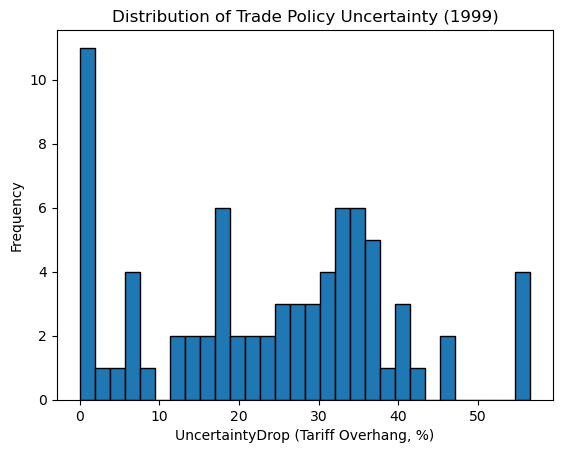

In [31]:
import matplotlib.pyplot as plt

plt.hist(uncertainty_df["UncertaintyDrop"], bins=30, edgecolor='black')
plt.xlabel("UncertaintyDrop (Tariff Overhang, %)")
plt.ylabel("Frequency")
plt.title("Distribution of Trade Policy Uncertainty (1999)")
plt.savefig("../figures/fig1.png", dpi=300)
plt.show()
